# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [15]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3, os, json

session = boto3.session.Session()
region = session.region_name

In [16]:
from PIL import Image
import io, requests

In [17]:
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch

In [18]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile


In [19]:
bucket= 'image-classification-dog-breeds-using-aws-sagemaker' 
role= sagemaker.get_execution_role()

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

##### Response

The dataset is composed of dog images grouped in 133 breeds. So the model will have to determine the right breed (supervised learning). The model which will be used is a resnet50 one.
The images are shared out between three groups : 
- train : 6680 images
- validation : 835 images
- test : 836 images
In each in these groups, we retrieve samples of the 133 breeds

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data

!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [8]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
! echo "$DEFAULT_S3_BUCKET"

image-classification-dog-breeds-using-aws-sagemaker


In [ ]:
!aws s3 sync ./dogImages/valid  s3://${DEFAULT_S3_BUCKET}/valid/

In [ ]:
!aws s3 sync ./dogImages/test  s3://${DEFAULT_S3_BUCKET}/test/

In [ ]:
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/train/

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [57]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.01),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
    "momentum" : ContinuousParameter(0.2, 0.3)
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [68]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    #instance_type="ml.m5.xlarge",
    instance_type="ml.p3.2xlarge",
    py_version='py3'
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type
)



In [69]:
os.environ['SM_CHANNEL_TRAINING']=f's3://{bucket}/'
os.environ['SM_MODEL_DIR']=f's3://{bucket}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{bucket}/output/'



In [70]:
!echo ${SM_CHANNEL_TRAINING}
!echo ${SM_MODEL_DIR}
!echo ${SM_OUTPUT_DATA_DIR}

s3://image-classification-dog-breeds-using-aws-sagemaker/
s3://image-classification-dog-breeds-using-aws-sagemaker/model/
s3://image-classification-dog-breeds-using-aws-sagemaker/output/


In [71]:
# TODO: Fit your HP Tuner
tuner.fit({"training": f"s3://{bucket}/"}, wait=True) # TODO: Remember to include your data channels


...........................................................................................................................................................................................................................................................................................................................!


In [72]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()    #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-02-09 15:25:19 Starting - Preparing the instances for training
2022-02-09 15:25:19 Downloading - Downloading input data
2022-02-09 15:25:19 Training - Training image download completed. Training in progress.
2022-02-09 15:25:19 Uploading - Uploading generated training model
2022-02-09 15:25:19 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.002221313301563688',
 'momentum': '0.2585090173694057',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2022-02-09-14-59-12-594"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-416312206633/pytorch_dog_hpo-2022-02-09-14-59-12-594/source/sourcedir.tar.gz"'}

In [73]:
hyperparameters = best_estimator.hyperparameters()           # if no stopping of the notebook instance
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate'], \
                   "momentum": best_estimator.hyperparameters()['momentum'], \
                   "epochs": 10}

###############            OR            #################

## Recovered after work interruption -> to avoid to launch a costing hyperparameter tuning job again
## Hyperparameter values can be obtained from above 
# or from console ("Best training job hyperparameters" of the "Best training job" tab for the global hyperparameter tuning job)

#hyperparameters = {"batch_size": '32', \
                   #"learning_rate": '0.04373395316301027', \
#                   "learning_rate": '0.0013417273091346344', \
#                   "momentum": '0.25', \
#                   "epochs": '10'}


In [74]:
hyperparameters

{'batch_size': 32,
 'learning_rate': '0.002221313301563688',
 'momentum': '0.2585090173694057',
 'epochs': 10}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [75]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),

    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),    
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    ProfilerRule.sagemaker(rule_configs.GPUMemoryIncrease()),    
    ProfilerRule.sagemaker(rule_configs.OverallSystemUsage())
]

In [76]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "10"
    }
)
#hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [77]:
# TODO: Create and fit an estimator

# TODO: Your estimator here
estimator = PyTorch(
    entry_point='train_model.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    #instance_type='ml.m5.xlarge',
    instance_type='ml.p3.2xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

estimator.fit({"training": f"s3://{bucket}/"}, wait=True)

2022-02-09 15:36:46 Starting - Starting the training job...
2022-02-09 15:37:13 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
GPUMemoryIncrease: InProgress
OverallSystemUsage: InProgress
.........
2022-02-09 15:38:45 Downloading - Downloading input data.........
2022-02-09 15:40:17 Training - Downloading the training image......
2022-02-09 15:41:17 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-09 15:41:03,648 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-09 15:41:03,673 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-09 15:41:03,677 sagemaker_pytorch_container.training INFO     Invoking

In [78]:
# TODO: Plot a debugging output.

In [79]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: dog-pytorch-2022-02-09-15-36-45-891
Region: us-east-1


In [80]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-416312206633/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-416312206633/dog-pytorch-2022-02-09-15-36-45-891/profiler-output


Profiler data from system is available


In [81]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-02-09 16:01:18.272 ip-172-16-120-234:14694 INFO metrics_reader_base.py:134] Getting 20 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


In [82]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-02-09 16:01:27.814 ip-172-16-120-234:14694 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-416312206633/dog-pytorch-2022-02-09-15-36-45-891/debug-output
[2022-02-09 16:01:28.085 ip-172-16-120-234:14694 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4727 more expected)', IncompleteRead(0 bytes read, 4727 more expected)) while reading s3://sagemaker-us-east-1-416312206633/dog-pytorch-2022-02-09-15-36-45-891/debug-output/index/000000000/000000000150_worker_0.json . Will retry now


In [83]:
print(trial.tensor_names()) 

[2022-02-09 16:01:34.699 ip-172-16-120-234:14694 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-09 16:01:35.726 ip-172-16-120-234:14694 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu

In [84]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

209
30


In [85]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [86]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [87]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


In [88]:
# TODO: Display the profiler output

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

#### Response
Here is the debugging output : 

- VanishingGradient: Error
- Overfit: NoIssuesFound
- Overtraining: InProgress
- PoorWeightInitialization: IssuesFound

And the profiling output:
- LowGPUUtilization: IssuesFound
- ProfilerReport: IssuesFound
- GPUMemoryIncrease: NoIssuesFound
- OverallSystemUsage: NoIssuesFound
 


In [89]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-416312206633/dog-pytorch-2022-02-09-15-36-45-891/rule-output


In [90]:
! aws s3 ls {rule_output_path} --recursive

2022-02-09 15:57:48     370329 dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-09 15:57:47     219090 dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-09 15:57:44        556 dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-09 15:57:43      47699 dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-09 15:57:43        126 dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-09 15:57:43        130 dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-09 15:57:43       4781 dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2022-02-09 

In [91]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-416312206633/dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-416312206633/dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-416312206633/dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-416312206633/dog-pytorch-2022-02-09-15-36-45-891/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-4163122

In [92]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [93]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [94]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [95]:
model_location=estimator.model_data

In [96]:
model_location

's3://sagemaker-us-east-1-416312206633/dog-pytorch-2022-02-09-15-36-45-891/output/model.tar.gz'

In [97]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [98]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [99]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium') # TODO: Add your deployment configuration like instance type and number of instances

------------!

In [100]:
# TODO: Run a prediction on the endpoint

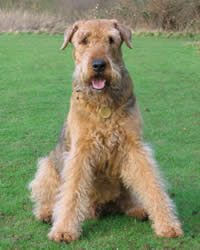

In [101]:
# EXAMPLE FROM LOCAL INSTANCE

# TODO: Your code to load and preprocess image to send to endpoint for prediction

with open("./dogImages/test/003.Airedale_terrier/Airedale_terrier_00179.jpg", "rb") as f:
    image = f.read()

Image.open(io.BytesIO(image))

In [102]:
predictor.predict(image)

[[0.010219525545835495,
  0.3256380259990692,
  2.3145861625671387,
  -0.9196708798408508,
  -0.6494110822677612,
  -0.3387654721736908,
  -0.8983826637268066,
  0.4761084020137787,
  0.41929343342781067,
  -0.29712221026420593,
  -0.24554508924484253,
  -0.20911195874214172,
  0.8170405030250549,
  -0.29449641704559326,
  -0.004524800926446915,
  -0.3086337745189667,
  0.5403481721878052,
  0.09218493103981018,
  0.5620986223220825,
  0.19416040182113647,
  -0.6873617768287659,
  -0.9978599548339844,
  -0.16942159831523895,
  0.7745107412338257,
  0.06658749282360077,
  0.8672685623168945,
  0.2561129033565521,
  -0.4105788469314575,
  -0.2131197601556778,
  0.9250456094741821,
  0.42495888471603394,
  -1.2301698923110962,
  0.4875023066997528,
  -0.3893764913082123,
  -0.3793346881866455,
  0.9910016059875488,
  -0.4967954456806183,
  0.7229206562042236,
  0.44619762897491455,
  -0.6553940773010254,
  0.06426258385181427,
  0.9465387463569641,
  -0.5382398366928101,
  0.3221822977066

In [103]:
# EXAMPLE OF PREDICTION FROM REMOTE S3

#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg"

image_remote = requests.get(request).content
#type(image_remote)

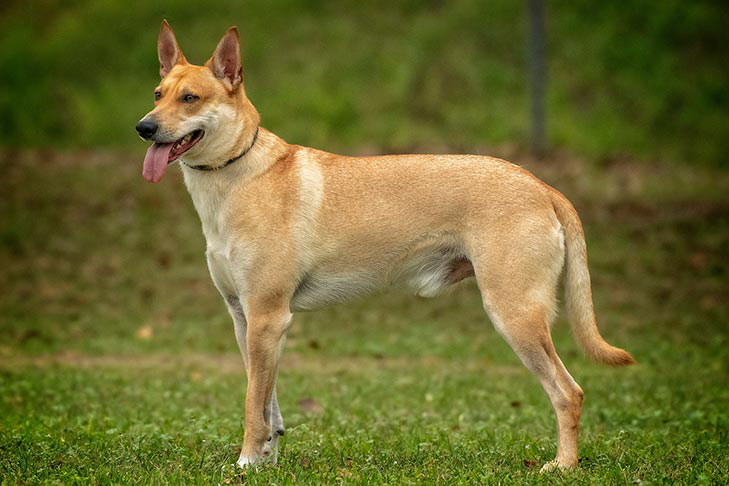

In [104]:
Image.open(io.BytesIO(image_remote))

In [105]:
response=predictor.predict(image_remote, initial_args={"ContentType": "image/jpeg"})
response[0]

[-0.5201745629310608,
 -0.5144021511077881,
 0.3897610604763031,
 1.3029062747955322,
 0.5667936205863953,
 -0.24967148900032043,
 1.0617948770523071,
 1.2654998302459717,
 -0.44870081543922424,
 0.6217529773712158,
 1.0874279737472534,
 0.24588468670845032,
 0.6113371849060059,
 1.8029488325119019,
 0.7172403931617737,
 0.2985230088233948,
 -0.9016160368919373,
 0.2492472529411316,
 -0.24637888371944427,
 1.793900489807129,
 0.15510189533233643,
 0.49095502495765686,
 -0.38340944051742554,
 -0.7203891277313232,
 -0.17189204692840576,
 -0.720720648765564,
 0.7087463140487671,
 -0.09697799384593964,
 -0.43755480647087097,
 0.0036116018891334534,
 -0.3206970691680908,
 0.517261266708374,
 -1.1890467405319214,
 0.774908721446991,
 -0.30624908208847046,
 -0.902608335018158,
 -0.3099394142627716,
 -0.30164530873298645,
 0.8841336369514465,
 0.02763284742832184,
 0.7800343632698059,
 0.37648406624794006,
 1.2803492546081543,
 0.6672801971435547,
 0.18201105296611786,
 0.306432843208313,
 0.1

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()